# Assignment 6
Raghav Juyal \
EP20BTECH11018

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats, ndimage, optimize
import emcee

# Question 1
In 1919, two expeditions sailed from Britain to test if the light deflection from stars agrees \
with Einstein’s General Theory of Relativity. Einstein’s theory predicts a value of 1.74 arc-seconds,\
whereas Newtonian gravity predicts a value exactly half of that. The team by Eddington obtained a \
value of 1.61 ± 0.40 arc-seconds, while the team by Crommelin reported a value of 1.98 ± 0.16 arc-seconds. \
Calculate the Bayes factor between General Relativity and Newtonian gravity from those data, assuming Gaussian likelihoods.

In [2]:
# data from the given question
time_einstein = 1.74           
time_newton = 0.87            
time_eddington = 1.61            
error_eddington = 0.40            
time_crommelin = 1.98             
error_crommelin = 0.16            

# pdf of Einstein-Eddington distribution
einstein_eddington_pdf = stats.norm(time_einstein,error_eddington).pdf(time_eddington)          
# pdf of Einstein-Cromelin distribution
einstein_crom_pdf = stats.norm(time_einstein,error_crommelin).pdf(time_crommelin)
# pdf of Newton-Eddington distribution
newton_eddington_pdf = stats.norm(time_newton,error_eddington).pdf(time_eddington)             
# pdf of Newton-Cromelin distribution 
newton_crom_pdf = stats.norm(time_newton,error_crommelin).pdf(time_crommelin)             

bayes_factor = (newton_crom_pdf*newton_eddington_pdf)/(einstein_crom_pdf*einstein_eddington_pdf)

print(f"Bayes factor between General Relativity and Newtonian gravity from the given data (assuming Gaussian Likelihoods) = {bayes_factor}")

Bayes factor between General Relativity and Newtonian gravity from the given data (assuming Gaussian Likelihoods) = 2.0762126610332088e-11


# Question 2
For exercise 1 in arXiv:1008.4686, calculate the 68% and 95% joint confidence intervals on b and m.

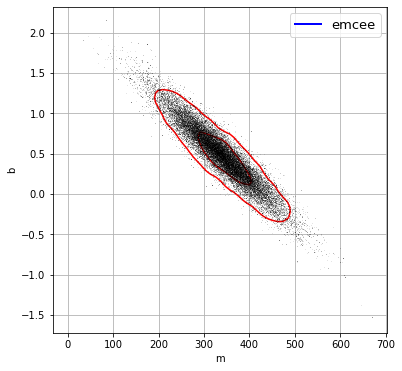

In [4]:
# utility function for log prior
def log_prior(theta):
    alpha, beta, sigma = theta
    if sigma < 0:
        return -np.inf
    else:
        return -1.5 * np.log(1 + beta ** 2) - np.log(sigma)

# utility function for log likelihood
def log_llihood(theta, x, y):
    a, b, s = theta
    y_model = a + b * x
    return -0.5 * np.sum(np.log(2 * np.pi * s ** 2) + (y - y_model) ** 2 / s ** 2)

# function for log posterior
def log_posterior(theta, x, y):
    return log_prior(theta) + log_llihood(theta, x, y)

# function for calculating sigma level
def sigma_level(t1, t2, nbins=20, smoothing=3):
    L, xbins, ybins = np.histogram2d(t1, t2, nbins)
    L[L == 0] = 1E-16
    logL = np.log(L)

    shape = L.shape
    L = L.ravel()

    i_sort = np.argsort(L)[::-1]
    i_unsort = np.argsort(i_sort)
    # cumulative sum
    L_cumsum = L[i_sort].cumsum()
    L_cumsum /= L_cumsum[-1]

    sigma = L_cumsum[i_unsort].reshape(shape)

    if smoothing > 1:
        sigma = ndimage.zoom(sigma, smoothing)
        xbins = np.linspace(xbins[0], xbins[-1], sigma.shape[0] + 1)
        ybins = np.linspace(ybins[0], ybins[-1], sigma.shape[1] + 1)

    xbins = 0.5 * (xbins[1:] + xbins[:-1])
    ybins = 0.5 * (ybins[1:] + ybins[:-1])
    return xbins, ybins, sigma


# utility function for plotting MCMC
def plot_MCMC(ax, xdata, ydata, t, scatter=False, nbins=20, smoothing=3, **kwargs):
    xbins, ybins, sigma = sigma_level(t[0], t[1], nbins, smoothing)
    ax.contour(xbins, ybins, sigma.T, levels=[0.68 ** 2, 0.95 ** 2], **kwargs)
    if scatter:
        ax.plot(t[0], t[1], ',k', alpha=0.1)
    ax.set_xlabel('m')
    ax.set_ylabel('b')


# given data
x = np.array([201, 244, 47, 287, 203, 58, 210, 202, 198, 158, 165, 201, 157, 131, 166, 160, 186, 125, 218, 146]) 
y = np.array([592,401, 583, 402, 495,173, 479, 504, 510, 416, 393, 442, 317, 311, 400, 337, 423, 334, 533, 344]) 
sigmay = np.array([61,25,38, 15 , 21 , 15, 27 , 14 , 30 , 16 , 14 , 25 , 52 , 16 , 34 , 31, 42 , 26 , 16 , 22 ]) 

# number of dimensions
ndim = 3 
# MCMC walkers
nwalkers = 50 
# burn period
nburn = 1000 
# number of MCMC steps
nsteps = 2000 

# defining intial guess
guesses = np.random.random((nwalkers, ndim))

# sampler value
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior,args=[x, y])
sampler.run_mcmc(guesses, nsteps)
emcee_ = sampler.chain[:, nburn:, :].reshape(-1, ndim).T

# plotting the required things
fig, ax = plt.subplots(figsize=(6,6))
plot_MCMC(ax, x, y, emcee_, True, colors='red', linewidths=1.5)
ax.plot([0, 0], [0, 0], 'blue', lw=2)
ax.legend(ax.lines[-1:] + ax.collections[::2], ['emcee'], fontsize=13)
plt.grid()
plt.show()

# Question 3
Fit the data in Table 1 of arXiv:1008.4686 to a straight line, after including all the \
data points, (after ignoring σx and ρxy) using both maximum likelihood analysis and using \
a Bayesian analysis to identify the outliers, using the same procedure as in the second of \
Jake VanDerPlas blog article. Show graphically the best fit line using both maximum \
likelihood analysis and also using Bayesian analysis, including the outlier points.

In [5]:
# mean squared error loss
def mse(theta, x=x, y=y, sigmay=sigmay):
    dy = y - theta[0] - theta[1] * x
    return np.sum(0.5 * (dy / sigmay) ** 2)

# utility function for finding Huber Loss
def huber_loss(t, c=3):
    return ((abs(t) < c) * 0.5 * t ** 2 + (abs(t) >= c) * -c * (0.5 * c - abs(t)))

# computes huber loss
def total_huber_loss(theta, x=x, y=y, sigmay=sigmay, c=3):
    return huber_loss((y - theta[0] - theta[1] * x) / sigmay, c).sum()

def log_prior(theta):
    if 1 > all(theta[2:]) > 0:
        return 0
    else:
        return -np.inf 

# function for log likelihood
def log_llhood(theta, x, y, sigmay, sigmaB):
    dy = y - theta[0] - x*theta[1] 
    temp = np.clip(theta[2:], 0, 1) 
    lL1 = np.log(temp) - 0.5 * np.log(2 * np.pi * sigmay ** 2) 
    lL1=lL1- 0.5 * (dy / sigmay) ** 2
    lL2 = np.log(1 - temp) - 0.5 * np.log(2 * np.pi * sigmaB ** 2) 
    lL2+=- 0.5 * ((dy / sigmaB) ** 2)
    su =  np.sum(np.logaddexp(lL1, lL2))
    return su

def log_posterior(theta, x, y, sigmay, sigmaB):
    return log_prior(theta) + log_llhood(theta, x, y, sigmay, sigmaB)

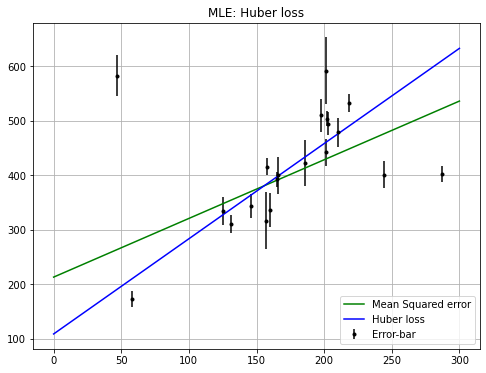

In [6]:
# optimized parameters from mean squared loss
theta1 = optimize.fmin(mse, [0, 0], disp=False)
# optimized parameters from huber loss
theta2 = optimize.fmin(total_huber_loss, [0, 0], disp=False)

# data
x = np.array([201,244,47,287,203,58,210,202,198,158,165,201,157,131,166,160,186,125,218,146])
y = np.array([592,401,583,402,495,173,479,504,510,416,393,442,317,311,400,337,423,334,533,344])
sigmay= np.array([61,25,38,15,21,15,27,14,30,16,14,25,52,16,34,31,42,26,16,22])

# defining points on x-axis
x_1 = np.linspace(0, 300, 1000)

# plotting the required things
plt.figure(figsize=(8,6))
plt.errorbar(x, y, sigmay, fmt='.k', label='Error-bar')
plt.plot(x_1, theta1[0] + x_1*theta1[1] , color='g', label='Mean Squared error')
plt.plot(x_1, theta2[0] + x_1*theta2[1], color='b', label='Huber loss')
plt.title('MLE: Huber loss')
plt.legend()
plt.grid()
plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_13080\1873603062.py:24: RuntimeWarning: divide by zero encountered in log
  lL1 = np.log(temp) - 0.5 * np.log(2 * np.pi * sigmay ** 2)
c:\Users\Admin\anaconda3\lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
C:\Users\Admin\AppData\Local\Temp\ipykernel_13080\1873603062.py:26: RuntimeWarning: divide by zero encountered in log
  lL2 = np.log(1 - temp) - 0.5 * np.log(2 * np.pi * sigmaB ** 2)


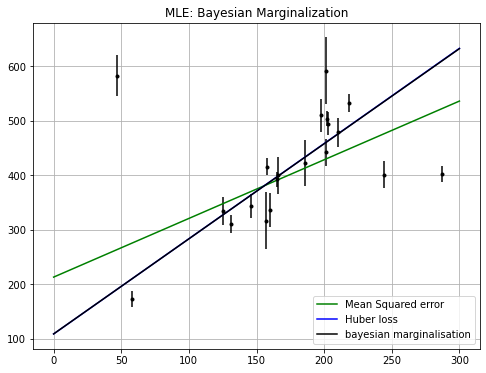

In [7]:
# dimensions in the model
ndim = 2 + len(x) 
# number of MCMC walkers
nwalkers = 50 
# burn rate
nburn = 10000 
# number of steps
nsteps = 15000  

# for initial guess
starting_guesses = np.zeros((nwalkers, ndim))
starting_guesses[:, :2] = np.random.normal(theta2, 1, (nwalkers, 2))
starting_guesses[:, 2:] = np.random.normal(0.5, 0.1, (nwalkers, ndim - 2))

# computes sampler value
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[x, y, sigmay, 50])
sampler.run_mcmc(starting_guesses, nsteps)

sample = sampler.chain 
sample = sampler.chain[:, nburn:, :].reshape(-1, ndim)

# bayesian marginalisation
theta3 = np.mean(sample[:, :2], 0)
g = np.mean(sample[:, 2:], 0)
# outliers
outliers = (g < 0.38)

# plotting the required things
plt.figure(figsize=(8,6))
plt.errorbar(x, y, sigmay, fmt='.k')
plt.plot(x_1, theta1[0] + x_1*theta1[1], color='g', label='Mean Squared error')
plt.plot(x_1, theta2[0] + x_1*theta2[1] ,color='b', label='Huber loss')
plt.plot(x_1, theta3[0] +  x_1* theta3[1] , color='black', label='bayesian marginalisation')
plt.grid()
plt.legend()
plt.title('MLE: Bayesian Marginalization');
plt.show()